### El objetivo de este proyecto es desarrollar un modelo de predicción que permita estimar el precio de vehículos de segunda mano.  Por consiguiente la variable objetivo es el "Precio".

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import pyspark
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error, r2_score

#=======================================================================================
#  Estudio Inicial de Columnas, Nullidad de la Data y Carateristicas de las Variables
#=======================================================================================
def estudo_Nullidad_caracteristicas(datosgenerales):
    columnas_numericas = datosgenerales.select_dtypes(include='number')
    columnas_categoricas = datosgenerales.select_dtypes(include=['object', 'category', 'bool'])
    resumen_numericas = pd.DataFrame({
        'columna': columnas_numericas.columns,
        'tipo': columnas_numericas.dtypes.values,
        'no_nulos': columnas_numericas.notnull().sum().values
    }).sort_values(by='no_nulos', ascending=False)
    resumen_categoricas = pd.DataFrame({
        'columna': columnas_categoricas.columns,
        'tipo': columnas_categoricas.dtypes.values,
        'no_nulos': columnas_categoricas.notnull().sum().values
    }).sort_values(by='no_nulos', ascending=False)
    print("📊 Columnas numéricas ordenadas (por cantidad de registros no nulos):")
    for _, fila in resumen_numericas.iterrows():
        print(f" - {fila['columna']} ({fila['no_nulos']} registros no nulos)")
    print(f"\nTotal columnas numéricas: {len(resumen_numericas)}")
    print("\n🔠 Columnas categóricas ordenadas (por cantidad de registros no nulos):")
    for _, fila in resumen_categoricas.iterrows():
        print(f" - {fila['columna']} ({fila['no_nulos']} registros no nulos)")
    print(f"\nTotal columnas categóricas: {len(resumen_categoricas)}")
    print(datosgenerales.shape)

#===============================================================================
#                Cargar Archivos
#===============================================================================
def columnas_con_ceros(df):
    total_filas = len(df)
    conteo_ceros = (df == 0).sum()
    columnas_con_ceros = conteo_ceros[conteo_ceros > 0]
    porcentaje_ceros = (columnas_con_ceros / total_filas * 100).round(2).astype(str) + '%'
    resultado = pd.DataFrame({
        'Total_Ceros': columnas_con_ceros,
        'Porcentaje': porcentaje_ceros    })
    return resultado

#===============================================================================
#                Box Plots 2
#===============================================================================
def box_plots_2(dataframe2,variables):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4)) 
    for i, var in enumerate(variables):
        sns.boxplot(ax=axes[i], y=dataframe2[var])  
        axes[i].set_title(f'{var}', fontsize=10)
        axes[i].tick_params(labelsize=8)
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()

#===============================================================================
#        Esta Grafica me permite el histograma de los datos
#===============================================================================
def graficar_histogramas(dataframe, columnas, filas, columnas_por_fila, bins=50):
    total = len(columnas)
    total_subplots = filas * columnas_por_fila
    fig, axes = plt.subplots(filas, columnas_por_fila, figsize=(5 * columnas_por_fila, 4 * filas))
    axes = axes.flatten()
    for i, col in enumerate(columnas):
        sns.histplot(data=dataframe, x=col, ax=axes[i], bins=bins)
        axes[i].set_title(f"Distribución de {col}")
    for j in range(len(columnas), total_subplots):
        fig.delaxes(axes[j]) 
    plt.tight_layout()
    plt.show()
#===============================================================================
#                Detectar Outliners
#===============================================================================
# Detectar outliers usando el método IQR
def Outlineers_IQR(dataframe2, variabless):
    outliers = {}

    for columna in variabless:
        Q1 = dataframe2[columna].quantile(0.25)
        Q3 = dataframe2[columna].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.8 * IQR
        outlier_indices = dataframe2[(dataframe2[columna] < lower_bound) | (dataframe2[columna] > upper_bound)].index
        outliers[columna] = len(outlier_indices)
        print(f"'{columna}': {len(outlier_indices)} outliers detectados.  Los cuartiles son: Q1:{Q1} Q3:{Q3} . lower_bound:{lower_bound} upper_bound:{upper_bound} ")
#===============================================================================
#                Esta Grafica me permite el histograma de los datos
#===============================================================================
def graficar_histogramas_autov(dataframe, columnas, bins=50):

    total = len(columnas)
    columnas_por_fila = 2  
    filas = math.ceil(total / columnas_por_fila)

    fig, axes = plt.subplots(filas, columnas_por_fila, figsize=(6 * columnas_por_fila, 4 * filas))
    axes = axes.flatten() 

    for i, col in enumerate(columnas):
        sns.histplot(data=dataframe, x=col, ax=axes[i], bins=bins)
        axes[i].set_title(f"Distribución de {col}")
        axes[i].grid(True)
    for j in range(len(columnas), len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
#===============================================================================
#                Grafico de Correlaciones
#===============================================================================
def Graf_Corre(dataframec,variablesc, tituloc):
    data_filtrada = dataframec[variablesc]
    plt.figure(figsize=(4, 3))
    sns.heatmap(data_filtrada.corr(), annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)
    plt.title(tituloc, fontsize=14)
    plt.show()
#===============================================================================
#                Grafico de Correlaciones Spearman
#===============================================================================
def Prueba_de_Spearman(dataFramSpe,corr_1,corr_2, Texxto):
    from scipy.stats import spearmanr
    df_limpio = dataFramSpe[[corr_1, corr_2]].dropna()
    corr_spearman, _ = spearmanr(df_limpio[corr_1], df_limpio[corr_2])
    print(Texxto, corr_spearman)

In [2]:
#===============================================================================
#                Cargar Archivos
#===============================================================================
Ruta_Arch = "../../vehicles.csv"
total_data= pd.read_csv(Ruta_Arch, sep = ",")

## Exploración inicial de los datos.


In [3]:
total_data.head(2)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN


### Estudio de las columnas, su tipo y Nulidad de la Data por Columna

In [4]:
estudo_Nullidad_caracteristicas(total_data)

📊 Columnas numéricas ordenadas (por cantidad de registros no nulos):
 - id (426880 registros no nulos)
 - price (426880 registros no nulos)
 - year (425675 registros no nulos)
 - odometer (422480 registros no nulos)
 - lat (420331 registros no nulos)
 - long (420331 registros no nulos)
 - county (0 registros no nulos)

Total columnas numéricas: 7

🔠 Columnas categóricas ordenadas (por cantidad de registros no nulos):
 - url (426880 registros no nulos)
 - region (426880 registros no nulos)
 - region_url (426880 registros no nulos)
 - state (426880 registros no nulos)
 - image_url (426812 registros no nulos)
 - posting_date (426812 registros no nulos)
 - description (426810 registros no nulos)
 - transmission (424324 registros no nulos)
 - fuel (423867 registros no nulos)
 - model (421603 registros no nulos)
 - title_status (418638 registros no nulos)
 - manufacturer (409234 registros no nulos)
 - type (334022 registros no nulos)
 - paint_color (296677 registros no nulos)
 - drive (29631

## Resumen de observaciones 1:

- La data está compuesta de **26 columnas**
- El número de registros es **426880**
- **7 columnas** son de datos numéricos
- **19 columnas** son de datos categóricos
- El número de registros Nullos de la columna "country" es **426880**, es decir, todos sus elementos son Nulos, por lo que esta columna esta completamente vacia y será eliminada.
- Tambien sera eliminada la columna id.

In [5]:
total_data2=total_data.copy()
total_data2 = total_data2.drop(columns=['county', 'id'])

#### El siguiente paso fue buscar los valores iguales a Cero en las columnas numéricas.  Las columnas 'price', 'odometer' y 'year' no deberian tener valores de cero; ya que no ha Vehiculos gratis,  ni del Año "Cero".  Sin embargo, odometer igual a cero, aunque no es tipico, no podria decirse que sea un dato incorrecto, ya que el vehiculo podria ser Segunda mano y nunca haber sido usado.

In [6]:
print(columnas_con_ceros(total_data2))

          Total_Ceros Porcentaje
price           32895      7.71%
odometer         1965      0.46%
long                1       0.0%


####  Estudo de las Variables numéricas (Histogramas y BoxPlot Exploratorios)

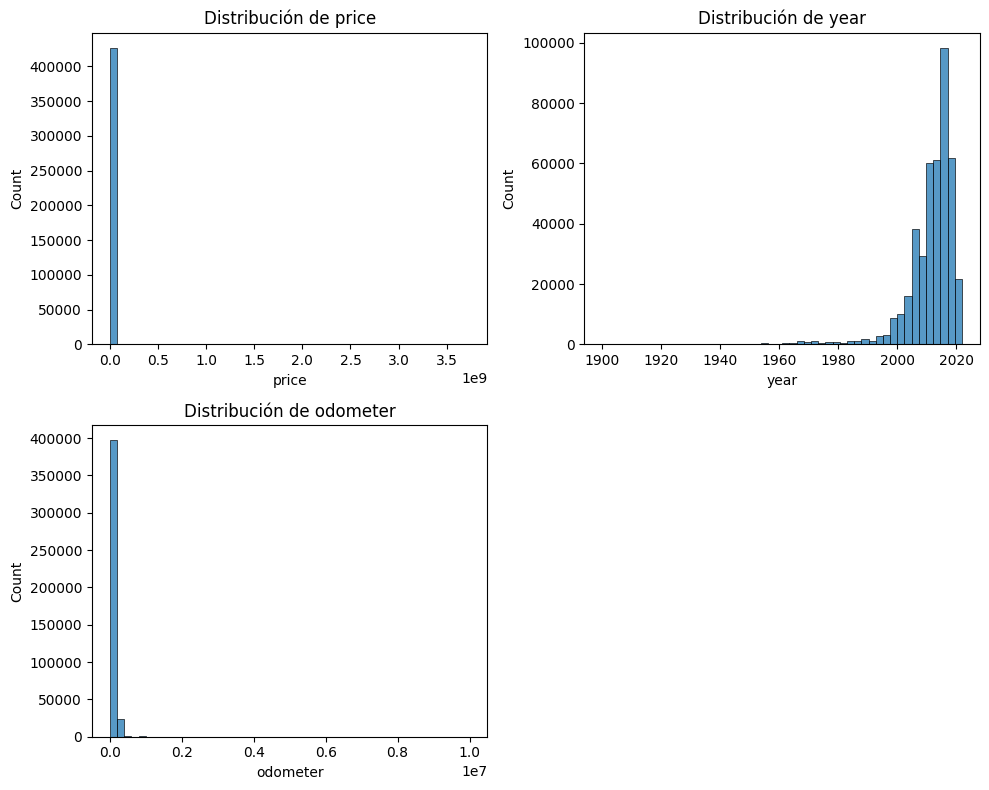

In [54]:
variables_numericas=['price', 'year', 'odometer']
graficar_histogramas(total_data2, variables_numericas,2,2)

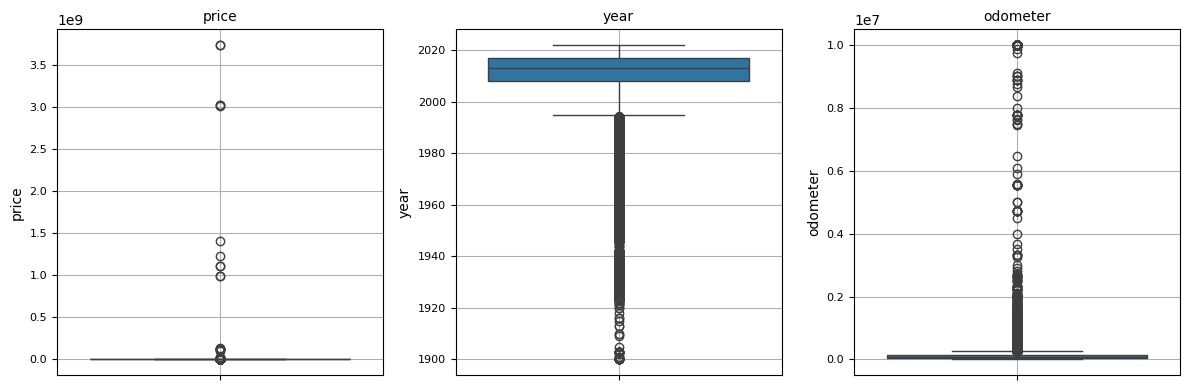

In [32]:
box_plots_2(total_data2, variables_numericas)

In [33]:
# Veamos una descripción estadistica de los campos numericos
print(total_data2.describe().round(2))

              price       year     odometer        lat       long
count  4.268800e+05  425675.00    422480.00  420331.00  420331.00
mean   7.519903e+04    2011.24     98043.33      38.49     -94.75
std    1.218228e+07       9.45    213881.50       5.84      18.37
min    0.000000e+00    1900.00         0.00     -84.12    -159.83
25%    5.900000e+03    2008.00     37704.00      34.60    -111.94
50%    1.395000e+04    2013.00     85548.00      39.15     -88.43
75%    2.648575e+04    2017.00    133542.50      42.40     -80.83
max    3.736929e+09    2022.00  10000000.00      82.39     173.89


#### Antes de empezar a estudir las relaciones de **"price"** con otras variables se procedio a observar la descripción estadistica de los datos numericos.  Los Outliners y su distribución a traves de los boxplots e Histogramas.

#### De aqui podemos ver que en Price hay al menos un valor **3.736929e+09** que hay que limpiar antes de hacer estudios.
#### Eso aunado a los valores de Cero "0" que observamos previamente en el **price** serian datos que producen perturbaciones estadisticas. .

#### Tambien debemos Eliminas los valores Null de los campos 'year' y 'odometer'

#### A continuacion se emplea el IQR para obtener una cota superior para 'price' y 'odometer'.  Y lo que este fuera de esas cotas sera eleiminado.

In [55]:
Outlineers_IQR(total_data2, variables_numericas)

'price': 5528 outliers detectados.  Los cuartiles son: Q1:5900.0 Q3:26485.75 . lower_bound:-24978.625 upper_bound:63540.1 
'year': 15896 outliers detectados.  Los cuartiles son: Q1:2008.0 Q3:2017.0 . lower_bound:1994.5 upper_bound:2033.2 
'odometer': 2884 outliers detectados.  Los cuartiles son: Q1:37704.0 Q3:133542.5 . lower_bound:-106053.75 upper_bound:306051.80000000005 


In [56]:
total_data3=total_data2.copy()

In [57]:
total_data3 = total_data3[(total_data3['price'] >= 500) & (total_data3['price'] <= 65000)]
total_data3 = total_data3[(total_data3['odometer'] >= 0) & (total_data3['odometer'] <= 320000)]
total_data3 = total_data3[['price', 'year', 'odometer']].dropna()

#### GRAFICAS DE LOS DATOS: 'price', 'year' & 'odometer' despues de la primera limpieza de los datos:

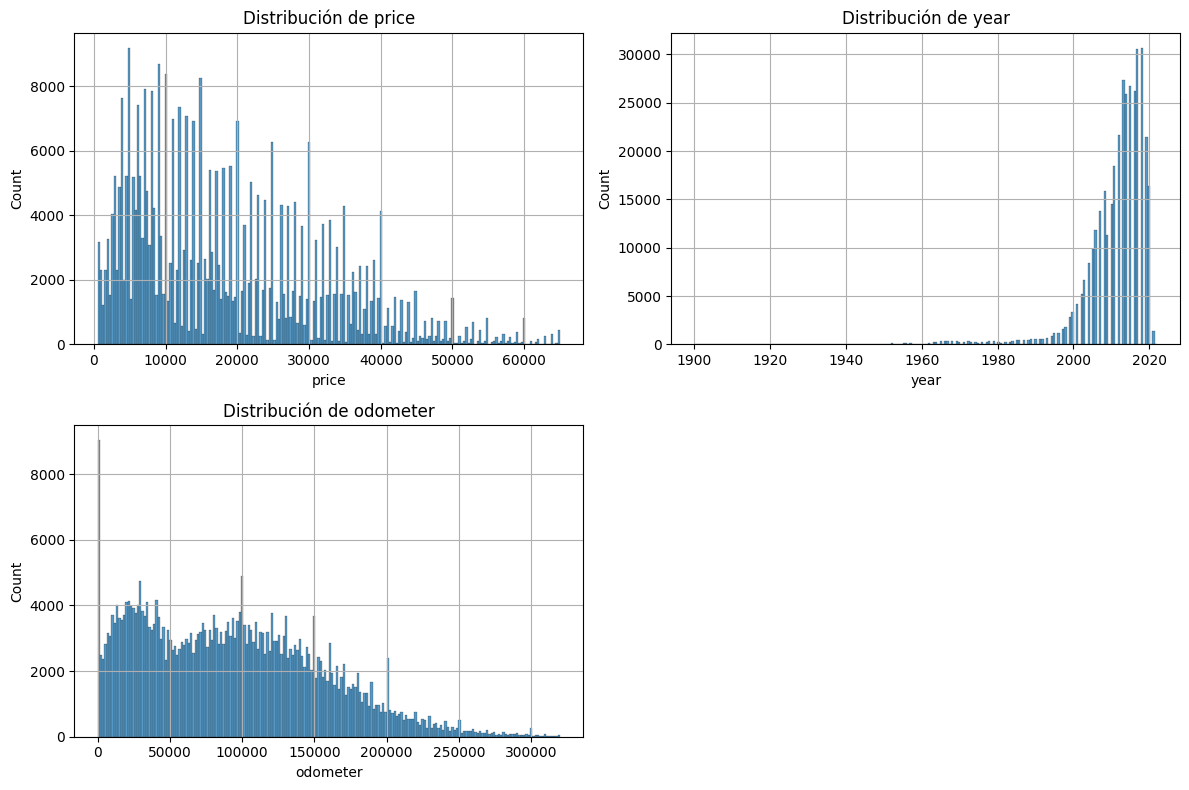

In [59]:
graficar_histogramas_autov(total_data3, variables_numericas, bins=200)

#### **price:**
- **Forma general**: claramente asimétrica positiva (sesgada a la derecha).
- **Asimetria**: 0.86, **Kurtosis**: 0.18.
- **Cola larga a la derecha**: Muchos vehículos tienen precios bajos, y pocos tienen precios muy altos.
- **Moda** en el tramo de los **5,000–15,000**.
- **Picos visibles**: Posiblemente por precios comunes/redondeados (**$10,000**, **$20,000**, etc.).

---

#### **odometer:**
- **Forma general**: claramente asimétrica positiva (sesgada a la derecha).
- **Skewness**: 0.53, **Kurtosis**: -0.26.
- La mayoría de los vehículos tienen **bajo kilometraje**, y hay una “**cola**” que se extiende hacia valores más altos.
- **No es una distribución normal**: no tiene forma de campana simétrica.
- Tampoco es **lineal ni uniforme**: no hay pendiente constante ni altura pareja en la frecuencia.

---
#### **year:**
- **Forma general**: Distribución **asimétrica negativa** (sesgada a la izquierda).
- **Concentración alta** entre los años **2000 y 2023**, con un pico cerca del **año 2015–2020**.
- **Cola hacia la izquierda**: Hay algunos registros antiguos (años 1950–1990), pero muy escasos.
- **No es normal**: No tiene simetría. Está claramente agrupada hacia años recientes.
- Podría reflejar el mercado actual de autos en venta, que naturalmente contiene **más autos modernos que antiguos**.


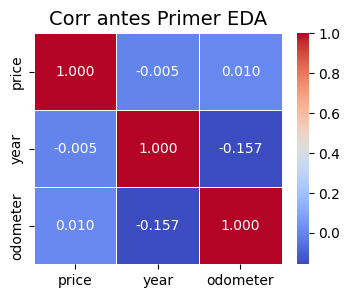

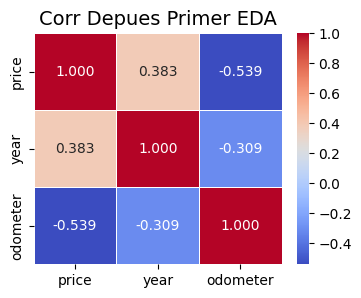

In [100]:
Graf_Corre(total_data2,variables_numericas, "Corr antes Primer EDA")
Graf_Corre(total_data3,variables_numericas, "Corr Depues Primer EDA")

##### - price vs year (0.38)	Correlación moderada positiva: los vehículos más nuevos tienden a tener precios más altos.
##### - price vs odometer (-0.54)	Correlación moderada negativa: a mayor kilometraje, menor es el preciónprecio.

##### Sin embargo corr() me da por default la prueba de Pearson, la cual funciona bien cuando las Distribuciones son Normales y Lineales.   Pero como observamos, ninguna de las tres estadisticas estudiadas posee Distribuciones Normales.   En este caso se recomienda ver las pruebas de Spearman que es mas apropiada para otras distribuciones.

In [94]:
Prueba_de_Spearman(total_data2,'price','year', "Spearman antes de la Limpieza")
Prueba_de_Spearman(total_data3,'price','year',"Spearman despues de la Limpieza")


Spearman antes de la Limpieza 0.4914690645149488
Spearman despues de la Limpieza 0.6702608751270743


In [99]:
Prueba_de_Spearman(total_data2,'price','odometer', "Spearman antes de la Limpieza")
Prueba_de_Spearman(total_data3,'price','odometer', "Spearman despues de la Limpieza")

Spearman antes de la Limpieza -0.45712789041975627
Spearman despues de la Limpieza -0.5938930363725081


CONCLUSION 2

Estudio de las Variables Categoricas